In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px 
import os
%matplotlib inline
sns.set(font_scale = 2, style='whitegrid',rc={'figure.figsize':(20,7)})

In [12]:
os.getcwd()

'/home/jupyter-t-varenichenko-22/My practice/Lesson_6'

In [2]:
ads_data = pd.read_csv('/home/jupyter-t-varenichenko-22/My practice/Lesson_6/For mini project/ads_data.zip')

In [16]:
ads_data.shape

(1000000, 11)

In [17]:
ads_data.head(5)

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям

In [40]:
ads_data_1 = ads_data.groupby(['event','ad_id'], as_index = False) \
                     .agg({'time': 'count'})\
                     .pivot(index = 'ad_id', columns = 'event', values = 'time') \
                     .reset_index()

ads_data_1 

event,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
3,2064,NaN,35.0
4,2132,1.0,58.0
...,...,...,...
960,122004,4.0,100.0
961,122013,NaN,156.0
962,122023,NaN,68.0
963,122031,1.0,138.0


In [42]:
# для подсчёта среднего по объявлениям заполнили наны. Округлили ответы до целых чисел.
ads_data_1.fillna(0).mean().round(0)

event
ad_id    57971.0
click      113.0
view       923.0
dtype: float64

Распределение показов объявлений

In [55]:
ads_data_2 = ads_data.groupby(['event','ad_id'], as_index = False) \
                     .agg({'time': 'count'})\
                     .query("event == 'view'")\
                     .time 

ads_ = np.log(ads_data_2) #доля объявлений с такими показами

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


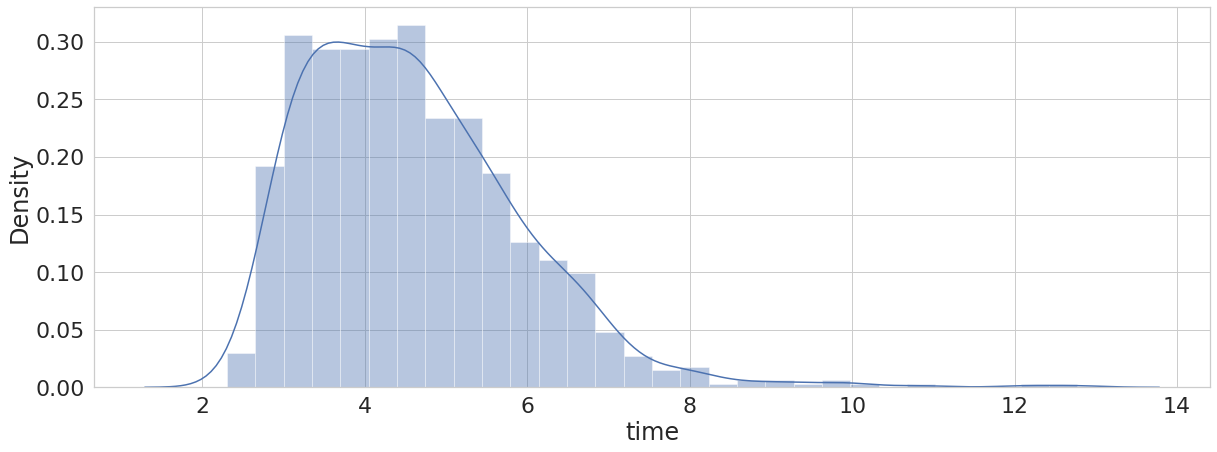

In [60]:
sns.distplot(ads_)

Найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов

In [84]:
by_date = ads_data.query("event == 'view'") \
                  .groupby(['date', 'ad_id'], as_index = False) \
                  .agg({'ad_id' : 'count'}) \                    # на этом этапе сгруппированно так, что идет один и тот же день подряд и кол-во раз
                  .groupby('date', as_index = False) \           # теперь сгруппировано по дням полностью
                  .agg({'ad_id' : 'mean'}) \                     
                  .rename(columns = {'ad_id' : 'mean_norm'})

# После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.
by_date['rolling_mean'] = by_date.rolling(window = 2).mean().round(0) 

In [89]:
by_date

,date,mean_norm,rolling_mean
0,2019-04-01,154.482270,NaN
1,2019-04-02,137.786982,146.0
2,2019-04-03,163.952778,151.0
3,2019-04-04,675.901720,420.0
4,2019-04-05,919.109677,798.0
5,2019-04-06,277.122727,598.0


Посчитаем, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним
Дни, в которых скользящее среднее равно NaN, не учитываем.


In [91]:
by_date['modul'] = abs(by_date['rolling_mean'] - by_date['mean_norm'])
by_date

,date,mean_norm,rolling_mean,modul
0,2019-04-01,154.482270,NaN,NaN
1,2019-04-02,137.786982,146.0,8.213018
2,2019-04-03,163.952778,151.0,12.952778
3,2019-04-04,675.901720,420.0,255.901720
4,2019-04-05,919.109677,798.0,121.109677
5,2019-04-06,277.122727,598.0,320.877273


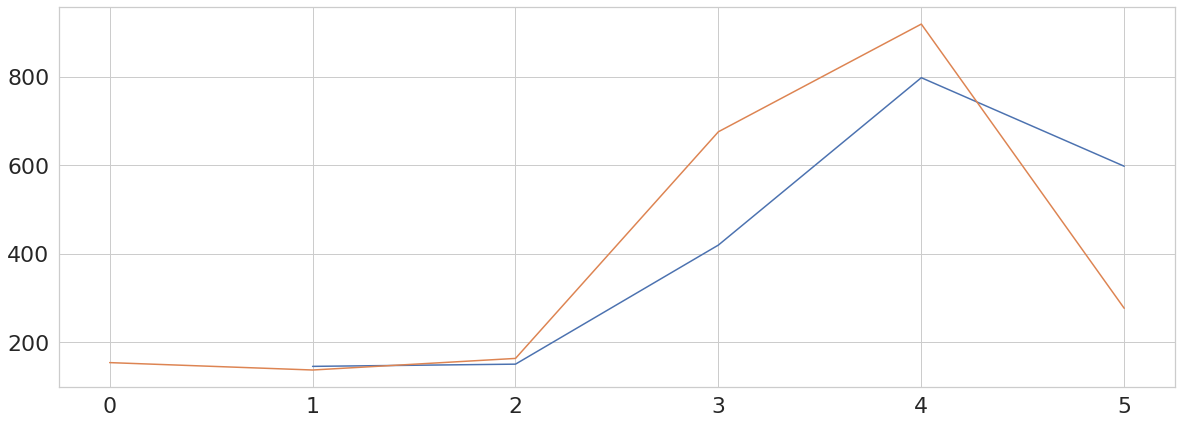

In [93]:
by_date.rolling_mean.plot()
by_date.mean_norm.plot()

In [104]:
ads_clients = pd.read_csv('/home/jupyter-t-varenichenko-22/My practice/Lesson_6/For mini project/ads_clients_data.csv')
ads_clients.head(2)

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10


In [4]:
full_ads_data = ads_data.merge(ads_clients, on = 'client_union_id')
full_ads_data.shape

(1000000, 14)

Объединим данные рекламы с данными о рекламных клиентах 
и найдем среднее количество дней от даты создания рекламного клиента (create_date) 
и первым запуском рекламного объявления этим клиентом (date).

In [6]:
# 1. сначала переведем data и create_date в формат дат
full_ads_data['date_x'] = pd.to_datetime(full_ads_data['date_x'])
full_ads_data['create_date'] = pd.to_datetime(full_ads_data['create_date'])

# 2. создаем новую колонку с разницей создания клиента и первым запуском. Вычитаем из date_x так как позже произошло
# можно было через модуль abs
full_ads_data = full_ads_data.assign(difference = full_ads_data.date_x - full_ads_data.create_date)
full_ads_data.shape             

(1000000, 15)

In [103]:
full_ads_data.head(2)

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,difference,cut,to_first,less_365
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days,3 month,NaT,True
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days,3 month,98 days,True


Посмотрим минимум дней от создания до первого запуска

In [138]:
full_ads_data.groupby('client_union_id')\
             .agg({'difference' : 'min'}).mean()

difference   124 days 09:04:43.532219570
dtype: timedelta64[ns]

Поделим клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.
Определим, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней)

In [53]:
bins = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d'])
labels = ['month', '30-90', '90-180', '180-365']

# так как в задании до первого запуска, надо смотреть на датафрейм из прошлого задания
# тут пересохранила его в новый дф
df = full_ads_data.groupby('client_union_id', as_index = False).agg({'difference' : 'min'})

# дальше только разделить на подготовленные промежутки  и посчитать сколько раз встречались значения
df['cut'] = pd.cut(df.difference, bins, labels = labels)
df.cut.value_counts()


90-180     396
30-90      263
180-365    168
month       11
Name: cut, dtype: int64

Построим интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них 

In [55]:
fig = px.bar(df, x='cut')
fig.show()
